In [9]:
import json
import gensim
import numpy as np
import pandas as pd
from collections import defaultdict
from gensim.models import Word2Vec
from pycorenlp import StanfordCoreNLP
from scipy.special import softmax
import tensorflow_text as text
import tensorflow_hub as hub

In [10]:
class SelfAttention():
    # hidden_dim is the size of the output vectors
    # produced by each of the three linear transformations.
    def __init__(self, input_dim, hidden_dim=16):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim if hidden_dim is not None else input_dim // 2

        self.query = np.random.randn(self.input_dim, self.hidden_dim)
        self.key = np.random.randn(self.input_dim, self.hidden_dim)
        self.value = np.random.randn(self.input_dim, self.hidden_dim)

    def forward(self, x):
        q = np.dot(x, self.query)
        k = np.dot(x, self.key)
        v = np.dot(x, self.value)

        scores = np.matmul(q, k.transpose().astype(
            np.float32)) / np.sqrt(q.shape[-1])

        weights = softmax(scores, axis=-1)
        weighted_values = np.matmul(weights, v)

        return weighted_values


In [24]:
class FeatureExtraction:

    def __init__(self, batch_size=5, window=5, min_count=2, vector_size=100, workers=2, glove_epoch=100,
                 matrix_window_size=3, hidden_dim=64) -> None:
        self.batch_size = batch_size
        self.w2v_model = None
        self.glove_model = None
        self.window = window
        self.min_count = min_count
        self.vector_size = vector_size
        self.workers = workers
        self.glove_epoch = glove_epoch
        self.m_window_size = matrix_window_size
        self.hidden_dim = hidden_dim
        self.stn_nlp = StanfordCoreNLP('http://localhost:9999')
        gensim.utils.logging.getLogger().setLevel(gensim.utils.logging.ERROR)


    def __sentiment_scoring(self, text):
        output = self.stn_nlp.annotate(text, properties={
            'annotators': 'sentiment',
            'outputFormat': 'json'
        })
        sentiment_tree = json.loads(output)
        distro = sentiment_tree['sentences'][0]['sentimentDistribution']
        score = sentiment_tree['sentences'][0]['sentimentValue']
        # print(distro)
        return distro, score

    def create_word2vec_model(self, all_tweets):
        try:
            model = Word2Vec.load('./'+str(self.vector_size)+'w2v.model')
            self.w2v_model = model
            return model
        except:
            tweets = all_tweets['Tweet'].apply(gensim.utils.simple_preprocess)
            w2v_model = Word2Vec(
                window=self.window,
                min_count=self.min_count,
                workers=self.workers,
                vector_size=self.vector_size
            )

            w2v_model.build_vocab(tweets, progress_per=1000)
            w2v_model.train(tweets, total_examples=len(all_tweets['Tweet']),
                            epochs=w2v_model.epochs)
            w2v_model.save(str(self.vector_size)+'w2v.model')
            self.w2v_model = w2v_model
            return w2v_model

    def __create_vocab(self, all_tweets):
        tweets = []
        for i in all_tweets['Tweet']:
            tweets.append(i)

        vocab = set()
        for sentence in tweets:
            for word in sentence.split():
                vocab.add(word)
        vocab = list(vocab)
        vocab_size = len(vocab)
        return tweets, vocab, vocab_size

    def __coocurrence_matrix(self, all_tweets):
        tweets, vocab, vocab_size = self.__create_vocab(all_tweets)
        window_size = self.m_window_size
        co_matrix = np.zeros((vocab_size, vocab_size))
        word2idx = defaultdict(lambda: -1)
        for i, word in enumerate(vocab):
            word2idx[word] = i

        for sentence in tweets:
            words = sentence.split()
            for i, word in enumerate(words):
                for j in range(i - window_size, i + window_size + 1):
                    if j != i and j >= 0 and j < len(words):
                        co_matrix[word2idx[word], word2idx[words[j]]] += 1
        return co_matrix, word2idx

    def create_glove_model(self, all_tweets):
        try:
            glove_model = Word2Vec.load(
                './'+str(self.vector_size)+'glove.model')
        except:
            glove_model = Word2Vec(window=self.window, min_count=self.min_count,
                                workers=self.workers, vector_size=self.vector_size)
            co_matrix, word2idx = self.__coocurrence_matrix(all_tweets)
            tweets, vocab, vocab_size = self.__create_vocab(all_tweets)

            glove_model.build_vocab_from_freq(
                {word: sum(co_matrix[vocab.index(word)]) for word in vocab})
            glove_model.corpus_count = vocab_size

            glove_model.train(np.array(vocab), total_examples=len(
                all_tweets['Tweet']), epochs=self.glove_epoch)
            glove_model.save(str(self.vector_size)+'glove.model')

            self.glove_model = glove_model

    def __tokenize(self, text):
        return text.lower().split()

    def __word_embedding(slef, word, model):
        embedding_dim = model.vector_size
        if word in model.wv.key_to_index:
            return model.wv.get_vector(word)
        else:
            return np.zeros(embedding_dim)

    def __sentence_embedding(self, sentence, model):
        distro, score = self.__sentiment_scoring(sentence)
        tokens = self.__tokenize(sentence)
        embeddings = np.array(
            [self.__word_embedding(token, model) for token in tokens])
        self_attention = SelfAttention(embeddings.shape[-1], self.hidden_dim)
        weights = self_attention.forward(embeddings)
        weighted_embeddings = np.matmul(weights.reshape(
            weights.shape[1], weights.shape[0]), embeddings)
        sentence_embedding = np.sum(weighted_embeddings, axis=0)
        sentence_embedding = list(sentence_embedding) + distro + list(score)

        weighted_embeddings = weights.reshape(embeddings.shape[0],weights.shape[1], 1) * embeddings
        sentence_embedding = np.sum(weighted_embeddings, axis=0)
        sentence_embedding = list(sentence_embedding) + distro + list(score)
        return np.array(weights), np.array(embeddings), np.array(weighted_embeddings), np.array(sentence_embedding)

    def __generate_col_names(self, n_features):
        col_names = [f"feat_{i}" for i in range(n_features)]
        feature_df = pd.DataFrame(columns=col_names)
        return feature_df

    def word2vec_feature(self, all_tweets):
        w2v_feature_df = self.__generate_col_names(self.vector_size+7)
        weights_df = self.__generate_col_names(self.vector_size)
        embeddings_df = self.__generate_col_names(self.vector_size)
        w_embeddings_df = self.__generate_col_names(self.vector_size)


        i = 0

        while i < len(all_tweets):
            tweet = all_tweets.iloc[i]
            if len(tweet['Tweet']) == 0:
                i += 1
                continue
            weights, embeddings, weighted_embeddings, sentence_embedding = self.__sentence_embedding(
                tweet['Tweet'], self.w2v_model)
            
            print("weights  ", weights)
            # print("embeddings  ", embeddings)
            # print("weighted embeddings  ", weighted_embeddings)
            print("sentence embedding  ", sentence_embedding)
            
            feature_vectore = np.append(sentence_embedding, tweet['Label'])
            weights = np.append(weights, tweet['Label'])
            embeddings = np.append(embeddings, tweet['Label'])
            weighted_embeddings = np.append(weighted_embeddings, tweet['Label'])

            temp_df = pd.DataFrame(feature_vectore.reshape(-1, len(feature_vectore)),
                                    columns=[f"feat_{i}" for i in range(len(feature_vectore))])
            w2v_feature_df = pd.concat(
                [w2v_feature_df, temp_df], ignore_index=True)
            
            temp_df = pd.DataFrame(weights.reshape(-1, len(weights)),
                                   columns=[f"feat_{i}" for i in range(len(weights))])
            weights_df = pd.concat(
                [weights_df, temp_df], ignore_index=True)
            
            temp_df = pd.DataFrame(embeddings.reshape(-1, len(embeddings)),
                                   columns=[f"feat_{i}" for i in range(len(embeddings))])
            embeddings_df = pd.concat(
                [embeddings_df, temp_df], ignore_index=True)
            
            temp_df = pd.DataFrame(weighted_embeddings.reshape(-1, len(weighted_embeddings)),
                                   columns=[f"feat_{i}" for i in range(len(weighted_embeddings))])
            w_embeddings_df = pd.concat(
                [w_embeddings_df, temp_df], ignore_index=True)


            i = i+1
        return w2v_feature_df, weights_df, embeddings_df, w_embeddings_df

    def glove_feature(self, all_tweets):
        glove_feature_df = self.__generate_col_names(self.vector_size+7)
        i = 0
        while i < len(all_tweets):
            tweet = all_tweets.iloc[i]
            if len(tweet['Tweet']) == 0:
                i += 1
                continue
            feature_vectore = self.__sentence_embedding(
                tweet['Tweet'], self.glove_model)
            feature_vectore = np.append(feature_vectore, tweet['Label'])
            temp_df = pd.DataFrame(feature_vectore.reshape(-1, len(feature_vectore)),
                                columns=[f"feat_{i}" for i in range(len(feature_vectore))])
            glove_feature_df = pd.concat(
                [glove_feature_df, temp_df], ignore_index=True)
            i = i+1
        return glove_feature_df

    def bert_feature(self, all_tweets):
        bert_preproc = hub.KerasLayer('./models/bert_en_uncased_preprocess_3/')
        bert_encoder = hub.KerasLayer(
            './models/bert_en_uncased_L-12_H-768_A-12_4/')
        pre_proc_text = bert_preproc(all_tweets['Tweet'])
        embedding = bert_encoder(pre_proc_text)['pooled_output']
        embedding = embedding.numpy()

        i = 0
        scores = []
        for tweet in all_tweets['Tweet']:
            distro, score = self.__sentiment_scoring(tweet)
            scores.append(distro + list(score))
        
        bert_features = np.concatenate((embedding, np.array(scores)), axis=1)

        bert_features = np.hstack((bert_features, np.expand_dims(np.array(all_tweets['Label']), axis=1)))
        
        bert_features = pd.DataFrame(embedding)
        bert_features = pd.merge(
            bert_features, all_tweets[["Label"]], left_index=True, right_index=True)
        bert_feature_df = self.__generate_col_names(len(embedding[0])+1)
        bert_feature_df = pd.concat(
            [bert_features, bert_feature_df], ignore_index=True)
        return bert_features

    def select_model(self, model_name, all_tweets):
        if model_name == 'glove':
            self.create_glove_model(all_tweets=all_tweets)
            return self.glove_feature(all_tweets)

        elif model_name == 'w2v':
            self.create_word2vec_model(all_tweets)
            return self.word2vec_feature(all_tweets)

        elif model_name == 'bert':
            return self.bert_feature(all_tweets)
        else:
            raise ("Model not found!")

In [29]:

def extract_features(batch_size, window, matrix_window_size, vector_size, model):

    fe = FeatureExtraction(vector_size=vector_size, batch_size=batch_size,
                        window=window, matrix_window_size=matrix_window_size)
    
    chunksize = 50 
    all_tweets_iterator = pd.read_csv(
        './clpsych_all_tweets.csv', chunksize=chunksize)
    counter = 0
    # Process each chunk
    for chunk in all_tweets_iterator:
        chunk = chunk.dropna().drop(chunk.columns[0], axis=1)


        feature_df_chunk = fe.select_model(model_name=model, all_tweets=chunk)
        feature_df_chunk.to_csv(str(counter)+' clpsych_bert_feat_df.csv')

        counter += 1
        del chunk, feature_df_chunk


In [30]:
hyperparameters = {
    # shorted hyper parameters for testing purpose
    "second": {
        "batch_size": 3,
        "window": 2,
        "matrix_window_size": 2,
        "vector_size": 80,
        "max_depth": 80,
        "min_samples_split": 3
    }
}

In [ ]:
for hpm in hyperparameters:
    params = list(hyperparameters[hpm].values())
    print('extracting features for the following hyperparameters and model')
    extract_features(*params[:4], model='bert')


In [138]:
feat_df = pd.read_csv('./shen_bert_feat_df.csv')


In [139]:
feat_df.drop(feat_df.columns[0], axis=1, inplace=True)
feat_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '765', '766', '767', '768', '769', '770', '771', '772', '773', '774'],
      dtype='object', length=775)

In [142]:
bert_feats = np.array(feat_df.iloc[:, :-8])


In [144]:
labels = bert_feats[-1]
sentiment_scores = bert_feats[-2]
p_weights = bert_feats[-3, -6]
sentiment_scores.shape

(1495,)

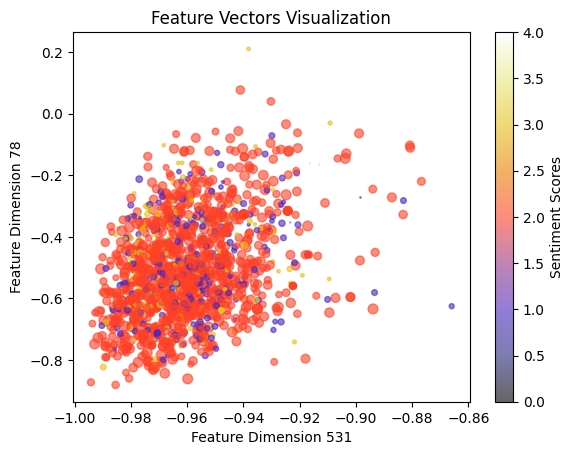

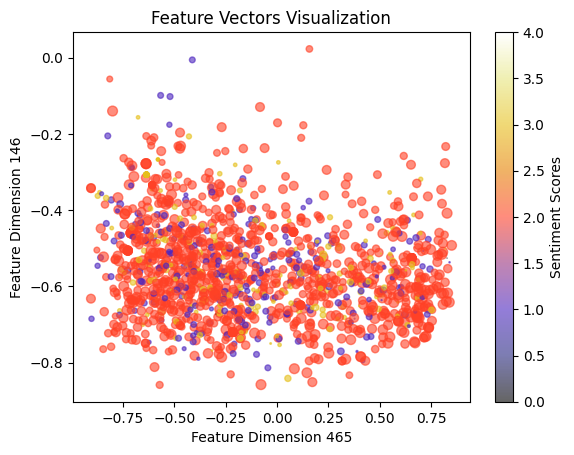

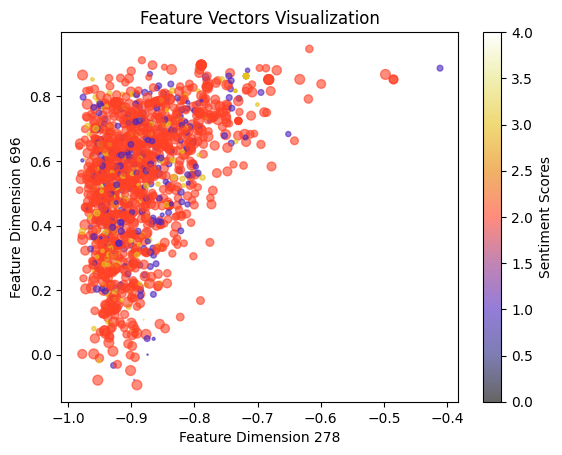

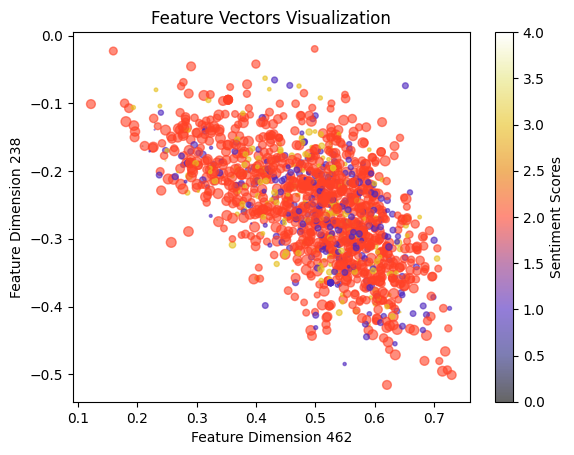

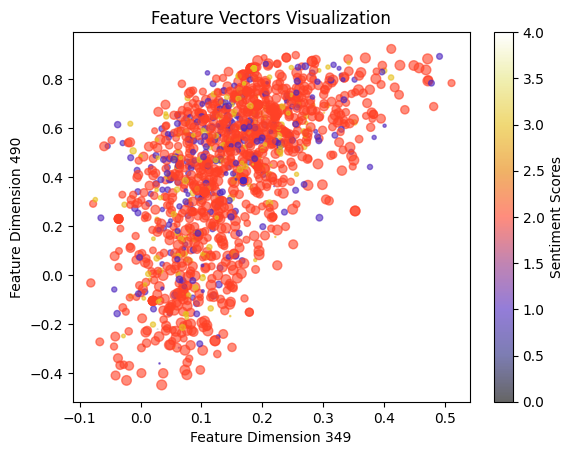

In [170]:
import matplotlib.pyplot as plt
import random

# Create a scatter plot
for i in range(5):
    f1 = random.randint(0, 767)
    f2 = random.randint(0, 767)
    plt.figure(i+1)
    plt.scatter(
        bert_feats[:, f1],  # X-axis values
        bert_feats[:, f2],  # Y-axis values
        c=sentiment_scores,  # Color based on sentiment scores
        # Size based on average probabilistic weights
        s=p_weights*50,
        cmap='CMRmap',  # Choose a color map
        alpha=0.6  # Set transparency
    )
    plt.xlabel('Feature Dimension '+ str(f1))
    plt.ylabel('Feature Dimension '+ str(f2))

    # Add colorbar for sentiment scores
    cbar = plt.colorbar()
    cbar.set_label('Sentiment Scores')

    # Set labels for the axes


    # Set a title for the plot
    plt.title('Feature Vectors Visualization')

    # Display the scatter plot
    plt.show()


/tmp/ipykernel_246286/3366358701.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


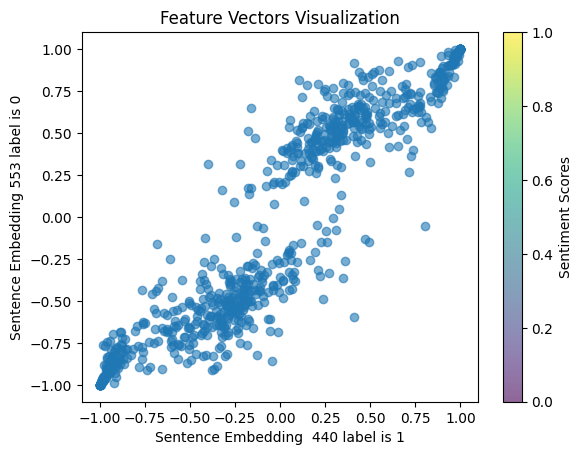

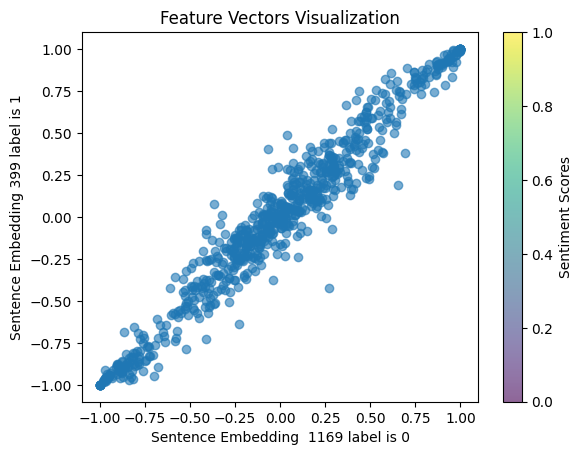

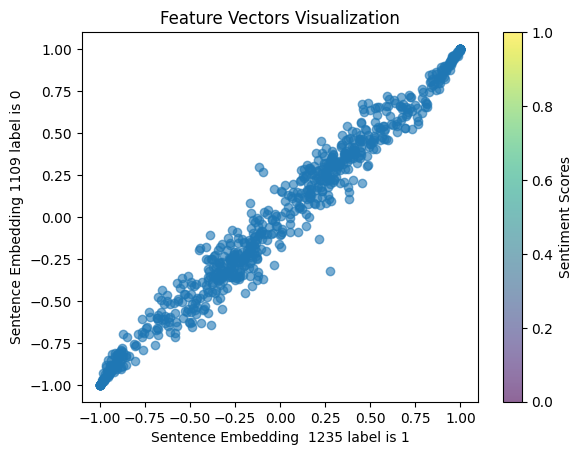

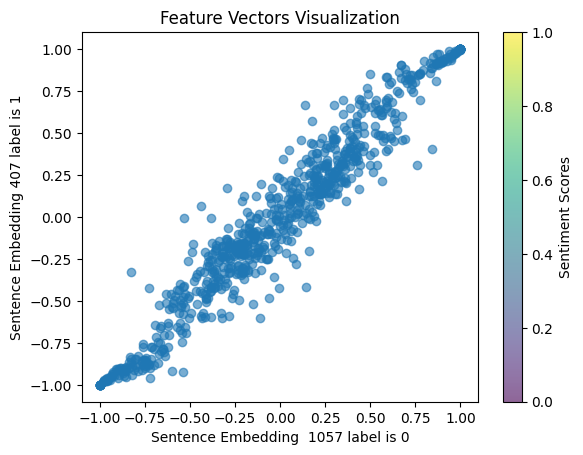

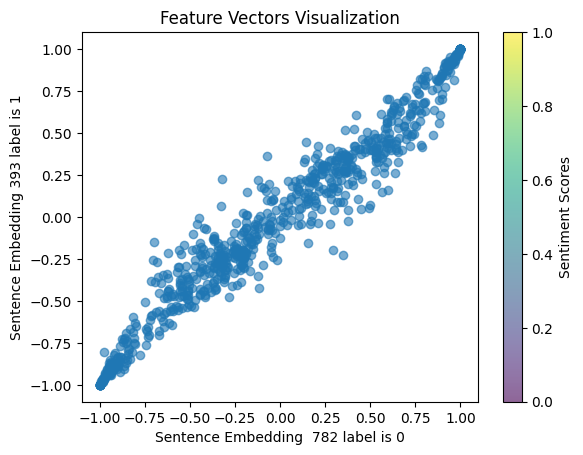

In [169]:
# Create a scatter plot
for i in range(5):
    f1 = random.randint(2, 1400)
    f2 = random.randint(2, 1400)
    plt.figure(i+1)
    plt.scatter(
        bert_feats[f1],  # X-axis values
        bert_feats[f2],  # Y-axis values
        c=sentiment_scores,  # Color based on sentiment scores
        # Size based on average probabilistic weights
        s=p_weights*50,
        cmap='CMRmap',  # Choose a color map
        alpha=0.6  # Set transparency
    )
    plt.xlabel('Sentence Embedding  ' + str(f1) +
               ' label is ' + str(labels[f1]))
    plt.ylabel('Sentence Embedding ' + str(f2) +
               ' label is ' + str(labels[f2]))

    # Add colorbar for sentiment scores
    cbar = plt.colorbar()
    cbar.set_label('Sentiment Scores')

    # Set a title for the plot
    plt.title('Feature Vectors Visualization')

    # Display the scatter plot
    plt.show()


In [172]:
g_feats_df = pd.read_csv('./glove80clp_feat_df.csv')

In [176]:
g_feats_df.drop(g_feats_df.columns[0], axis=1, inplace=True)

In [179]:
g_feats = np.array(g_feats_df.iloc[:, :-7])


In [ ]:
g_labels = np.array(g_feats_df.iloc[:, -1])

In [ ]:
g_sentiment_scores = np.array(g_feats_df.iloc[:, -2])

In [ ]:
g_p_weights = np.array(g_feats_df.iloc[:, -7:-2])

/tmp/ipykernel_246286/1155238412.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


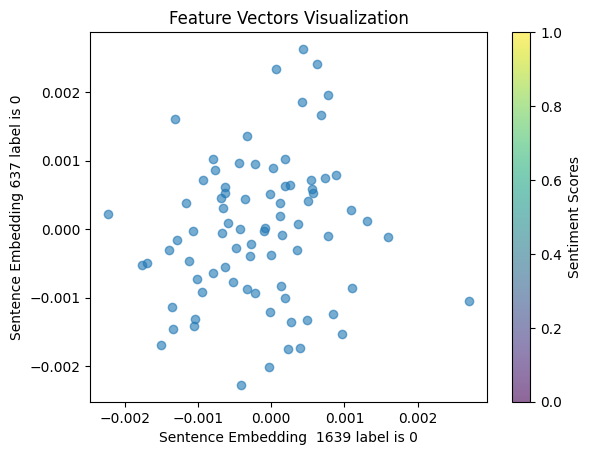

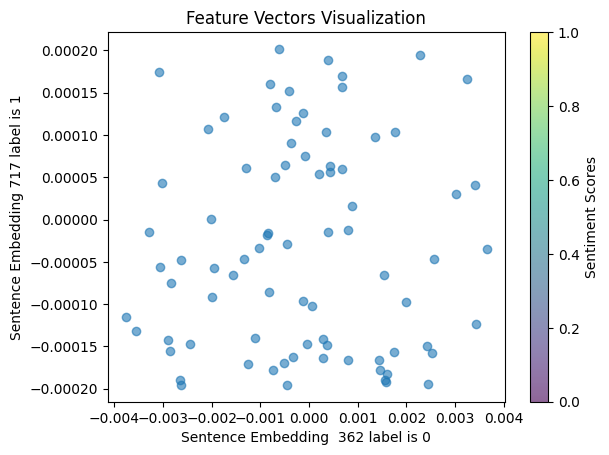

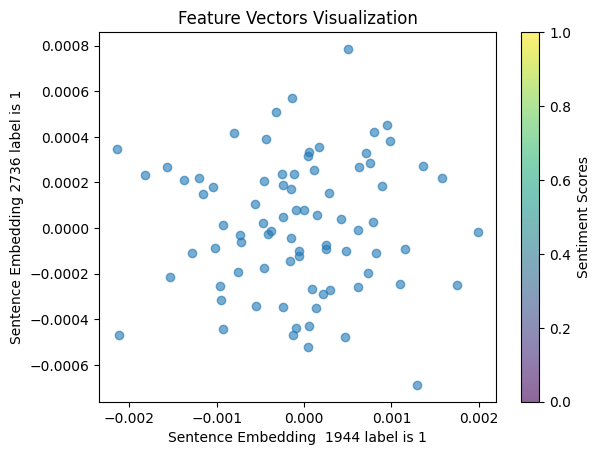

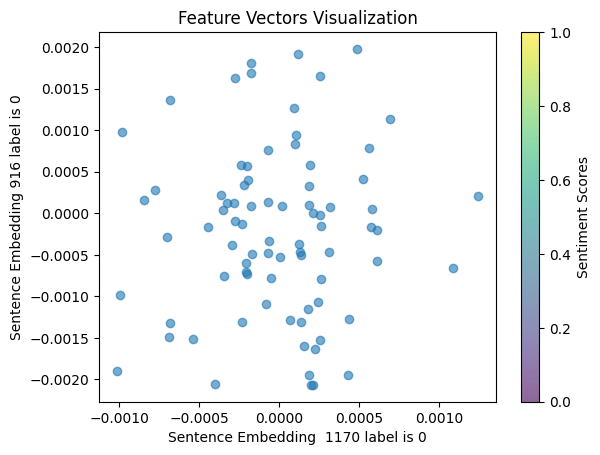

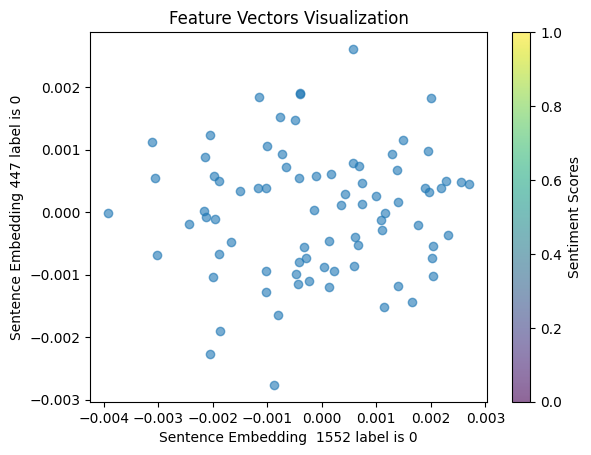

In [186]:
# Create a scatter plot
for i in range(5):
    f1 = random.randint(2, 2997)
    f2 = random.randint(2, 2997)
    plt.figure(i+1)
    plt.scatter(
        g_feats[f1],  # X-axis values
        g_feats[f2],  # Y-axis values
        c=sentiment_scores,  # Color based on sentiment scores
        # Size based on average probabilistic weights
        s=p_weights*50,
        cmap='CMRmap',  # Choose a color map
        alpha=0.6  # Set transparency
    )
    plt.xlabel('Sentence Embedding  ' + str(f1) +
               ' label is ' + str(g_labels[f1]))
    plt.ylabel('Sentence Embedding ' + str(f2) +
               ' label is ' + str(g_labels[f2]))

    # Add colorbar for sentiment scores
    cbar = plt.colorbar()
    cbar.set_label('Sentiment Scores')

    # Set labels for the axes

    # Set a title for the plot
    plt.title('Feature Vectors Visualization')

    # Display the scatter plot
    plt.show()


In [187]:
v_feat_df = pd.read_csv('./w2v80clp_feat_df.csv')
v_feat_df.drop(v_feat_df.columns[0], axis=1, inplace=True)

In [ ]:
v_feat = np.array(v_feat_df.iloc[:, :-7])

In [ ]:
v_labels = np.array(v_feat_df.iloc[:, -1])

/tmp/ipykernel_246286/1214480469.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


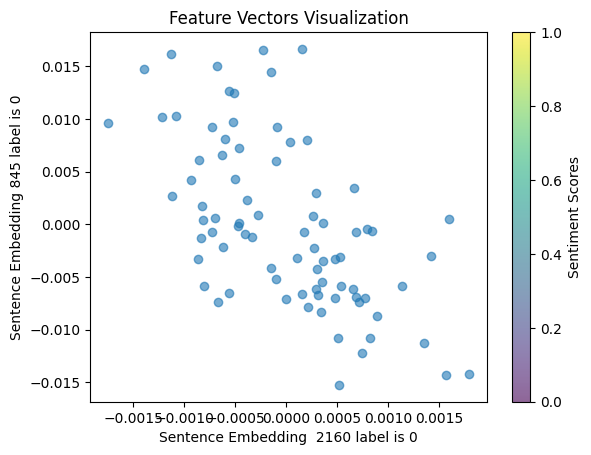

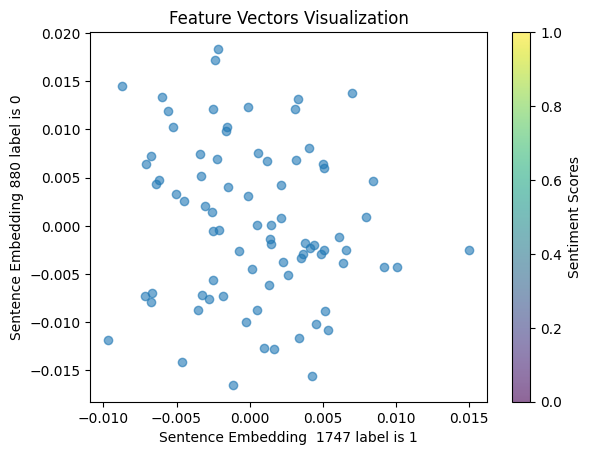

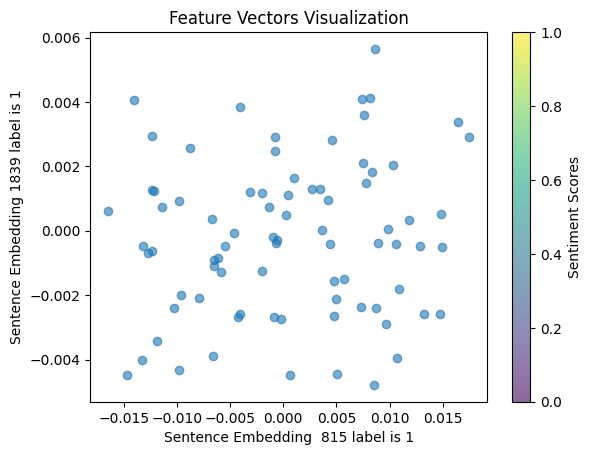

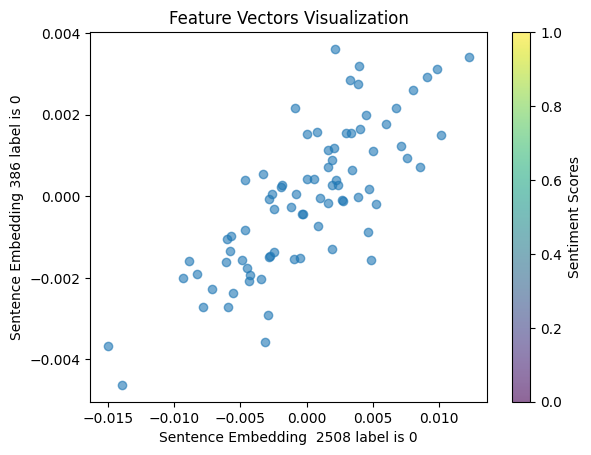

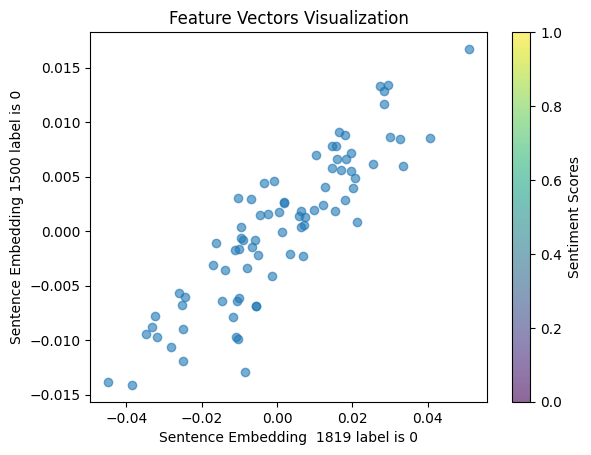

In [193]:
# Create a scatter plot
for i in range(5):
    f1 = random.randint(2, 2997)
    f2 = random.randint(2, 2997)
    plt.figure(i+1)
    plt.scatter(
        v_feat[f1],  # X-axis values
        v_feat[f2],  # Y-axis values
        cmap='CMRmap',  # Choose a color map
        alpha=0.6  # Set transparency
    )
    plt.xlabel('Sentence Embedding  ' + str(f1) +
               ' label is ' + str(g_labels[f1]))
    plt.ylabel('Sentence Embedding ' + str(f2) +
               ' label is ' + str(g_labels[f2]))

    cbar = plt.colorbar()
    cbar.set_label('Sentiment Scores')

    plt.title('Feature Vectors Visualization')

    plt.show()


In [159]:
att_weights = pd.read_csv('./shen_w2v_att_wieghts.csv')
att_weights.fillna(0, inplace=True)
att_weights.drop(att_weights.columns[0], axis=1, inplace=True)
embeddings = pd.read_csv('./shen_w2v_feat_df.csv')
embeddings.fillna(0, inplace=True)
embeddings.drop(embeddings.columns[0], axis=1, inplace=True)


In [160]:
att_weights = np.array(att_weights)

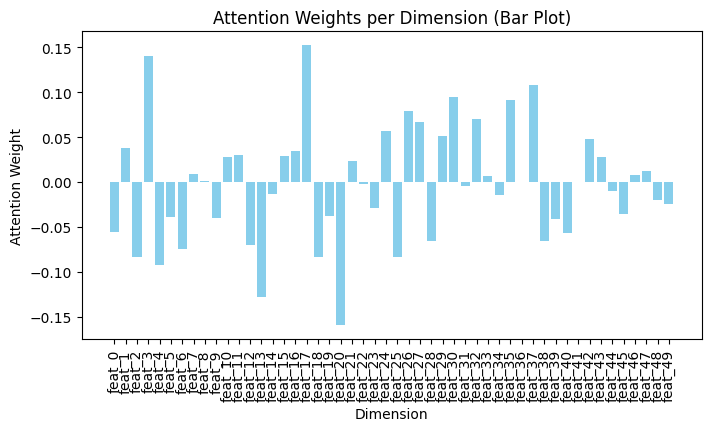

In [161]:

plt.figure(figsize=(8, 4))
plt.bar(embeddings.columns[:50], att_weights[0, 0:50], color='skyblue')
plt.xlabel('Dimension')
plt.ylabel('Attention Weight')
plt.title('Attention Weights per Dimension (Bar Plot)')
plt.xticks(rotation='vertical')
plt.show()
